In [1]:
    import numpy as np
    import math as math
    import pandas as pd
    import matplotlib.pyplot as plt
    from numpy.random import rand, randn
    from scipy.linalg import inv, svd
    from scipy.optimize import linprog
    from tqdm import tqdm_notebook as tqdm
    def null_space(A, rcond=None):
        u, s, vh = svd(A, full_matrices=True)
        M, N = u.shape[0], vh.shape[1]
        if rcond is None:
            rcond = np.finfo(s.dtype).eps * max(M, N)
        tol = np.amax(s) * rcond
        num = np.sum(s > tol, dtype=int)
        Q = vh[num:,:].T.conj()
        return Q

In [2]:
 def altproj(A, B, v0, n):
    
    "    Arguments:\n",
    "        A {numpy.ndarray} -- matrix whose column span is vector space U\n",
    "        B {numpy.ndarray} -- matrix whose column span is vector space W\n",
    "        v0 {numpy.ndarray} -- initialization vector\n",
    "        n {int} -- number of sweeps for alternating projection\n",
    "    Returns:\n",
    "        v {numpy.ndarray} -- the output after 2n steps of alternating projection\n",
    "        err {numpy.ndarray} -- the error after each full pass\n",
    "    \"\"\"\n",
    "    # Construct projection matrix\n",
    PU = np.dot(A,np.dot(inv(np.dot(A.T,A)),A.T))
    PW = np.dot(B,np.dot(inv(np.dot(B.T,B)),B.T))
    "    # Compute the exact solution\n",
    basis_UintW = np.hstack([A, B]) @ null_space(np.hstack([A, -B])) 
    P_UintW =  np.dot(basis_UintW,np.dot(inv(np.dot(basis_UintW.T,basis_UintW)),basis_UintW.T))
    v0_hat=np.dot(P_UintW,v0)
    "    # Apply n sweeps of alternating projection\n",
    v, err = v0, np.zeros(n)
    for t in tqdm(range(2 * n), total=2 * n, leave=False):
        if (t + 1) % 2 == 0:
            v = np.dot(PU, v) 
        else:
            v=np.dot(PW, v)
        if (t + 1) % 2 == 0:
            err[t // 2] =np.linalg.norm(v - v0_hat)
    return v, err

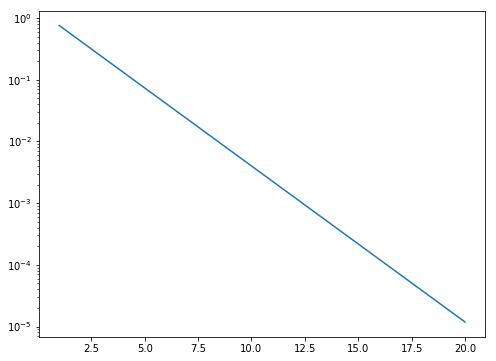

In [3]:
A = np.array([[3, 1, 4, 1, 5], [2, 5, 11, 17, 23], [3, 7, 13, 19, 29]]).T
B = np.array([[1, 2, 2, 2, 6], [1, 0, 1, 0, -3], [2.5, 6, 12, 18, 26]]).T
v0 = np.array([1, 2, 3, 4, 5])
n = 20
v, err = altproj(A, B, v0, n)
plt.figure(figsize=(8, 6))
plt.semilogy(np.arange(1, n + 1), err)

In [4]:
def kaczmarz(A, b, I):
    "    \"\"\"\n",
    "    Arguments:\n",
    "        A {numpy.ndarray} -- matrix defines the LHS of linear equation\n",
    "        b {numpy.ndarray} -- vector defines the RHS of linear equation\n",
    "        I {int} -- number of full passes through the Kaczmarz algorithm\n",
    "    Returns:\n",
    "        X {numpy.ndarray} -- the output of all I full passes\n",
    "        err {numpy.ndarray} -- the error after each full pass\n",
    "    \"\"\"\n",
    v0_hat=np.linalg.lstsq(A, b, rcond=None)[0]
    m, n = A.shape
    v, X, err = np.zeros(n), np.zeros((n, I)), np.zeros(I)
    for i in tqdm(range(I * m), total=I * m, leave=False):
        index=i%m
        ai =A[index, :]
        bi=b[index]
        num=(np.dot(ai,v)-bi)/np.dot(ai,ai)
        v=v-num*ai
        v = v - ((np.dot(v, ai) - bi)/np.dot(ai, ai))*ai
        if (i + 1) % m == 0:
            err[i // m]=np.linalg.norm(v - v0_hat)
            X[:, i // m] =v
    return X, err


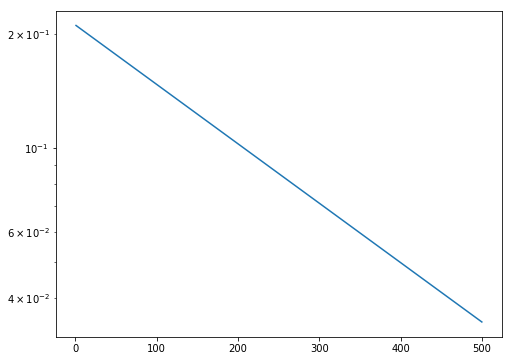

In [5]:
A = np.array([[2, 5, 11, 17, 23], [3, 7, 13, 19, 29]])
b = np.array([228, 277])
I = 500
X, err = kaczmarz(A, b, I)
plt.figure(figsize=(8, 6))
plt.semilogy(np.arange(1, I + 1), err)

Text(0.5,1,'norm of difference between xhat and Kaczmarz is 1.22e-09')

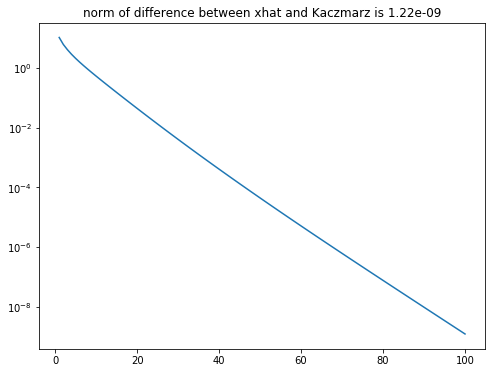

In [6]:
A = randn(500, 1000)
b = A @ randn(1000)
I = 100
X, err = kaczmarz(A, b, I)
plt.figure(figsize=(8, 6))
plt.semilogy(np.arange(1, I + 1), err)
#x_hat = np.dot(np.dot(A.T.conj(),inv(np.dot(A,A.T.conj()))),b)
x_hat = (A.T) @np.linalg.inv((A @ (A.T))) @b
plt.title(f'norm of difference between xhat and Kaczmarz is {np.linalg.norm(x_hat - X[:, -1]):.2e}')

In [20]:
def proj_HS(v, w, c):
  
    p = v if np.inner(v,w) >= c else v - ((np.dot(v, w)-c)/(np.power(np.linalg.norm(w),2)))*w
    
    return p
    
def proj_NB(v, a, v0):
 
    p = v if np.inner(v- v0, v-v0) <= a else a*(v -v0)/np.linalg.norm(v - v0) + v0
    return p

In [22]:
def lp_altproj(A, b, I):
    "    \"\"\"\n",
    "    Find a feasible solution for A v >= b using alternating projection\n",
    "    with every entry of v0 obeying Uniform[0,1]\n",
    "    Arguments:\n",
    "        A {numpy.ndarray} -- matrix defines the LHS of linear equation\n",
    "        b {numpy.ndarray} -- vector defines the RHS of linear equation\n",
    "        I {int} -- number of full passes through the alternating projection\n",
    "    Returns:\n",
    "        v {numpy.ndarray} -- the output after I full passes\n",
    "        err {numpy.ndarray} -- the error after each full pass\n",
    "    \"\"\"\n",
    m, n = A.shape
    "    # Apply I sweeps of alternating projection\n",
    v, err = np.zeros(n), np.zeros(I)
    for t in tqdm(range(I * m), total=I*m, leave=False):
        index=t%m
        ai =A[index]
        bi=b[index]
        v = proj_HS(v, ai, bi)
        if (t + 1) % m == 0:
            MMax = (b - A @ v).max()
            err[t // m] = MMax if MMax > 0 else 0
    return v, err
   

     con: array([], dtype=float64)
     fun: 1.8272050539280826e-12
 message: 'Optimization terminated successfully.'
     nit: 5
   slack: array([8.82960371e-13, 3.84137167e-13, 1.00000000e+00])
  status: 0
 success: True
       x: array([1.50428214e-12, 2.00000000e+00, 1.00000000e+00])


False True


array([1.00000000e-06, 2.00000177e+00, 9.99999093e-01])

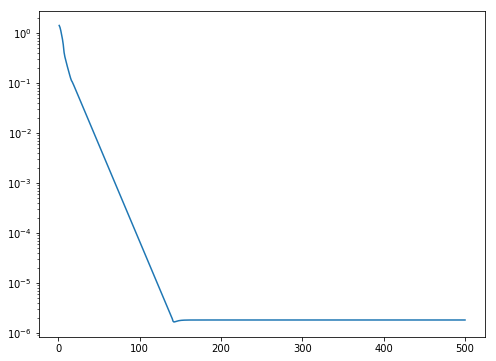

In [23]:
c = np.array([3, -1, 2])
A = np.array([[2, -1, 1], [1, 0, 2], [-7, 4, -6]])
b = np.array([-1, 2, 1])
res = linprog(c, A_ub=-A, b_ub=-b, bounds=[(0, None)] * c.size, method='interior-point')
print(res)
I = 500
"# Do not forget constraint xi >= 0\n",
A1 =np.vstack((A,-1*c,[[1,0,0],[0,1,0],[0,0,1]]))
b1 =np.hstack((b,[0,0,0,0]))
x, err = lp_altproj(A1, b1 + 1e-6, I)
plt.figure(figsize=(8, 6))
plt.semilogy(np.arange(1, I + 1), err)
print(np.all(A @ x - b > 0), np.all(x > 0))
x

True True [-1000.000001]
-1198.5327823524285


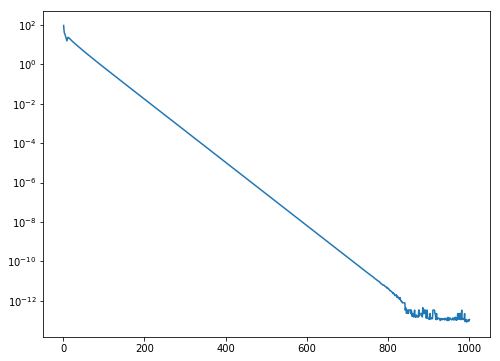

In [10]:
np.random.seed(0)
c = randn(1000)
A = np.vstack([-np.ones((1, 1000)), randn(500, 1000)])
b = np.concatenate([[-1000], A[1:] @ rand(1000)])
I, ep = 1000, 1e-6
"# Do not forget constraint xi >= 0, and c^T x <= -1000\n",
A1 = np.vstack((A,np.eye(A.shape[1]), -1 * c))
b1 = np.hstack((b,np.zeros(A.shape[1]),np.array([1000])))
x, err = lp_altproj(A1, b1 + ep, I)
print(np.all(A @ x - b > 0), np.all(x > 0), c.reshape(1, -1) @ x)
plt.figure(figsize=(8, 6))
plt.semilogy(np.arange(1, I + 1), err)
res = linprog(c, A_ub=-A, b_ub=-b, bounds=[(0, None)] * 1000, method='interior-point')
print(res.fun)

,feature,label
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0


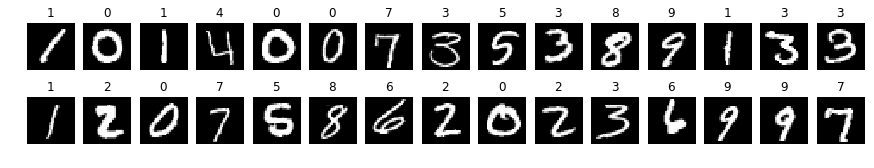

In [11]:
# read mnist csv file to a dataframe
df = pd.read_csv('mnist_train.csv')
# append feature column by merging all pixel columns
df['feature'] = df.apply(lambda row: row.values[1:], axis=1)
# only keep feature and label column
df = df[['feature', 'label']]
# display first 5 rows of the dataframe
plt.figure(figsize=(15, 2.5))
for i, row in df.iloc[:30].iterrows():
    x, y = row['feature'], row['label']
    plt.subplot(2, 15, i + 1)
    plt.imshow(x.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(y)
df.head()



In [12]:
def extract_and_split(df, d, test_size=0.5):
    target= df[df['label'] == d]
    label=np.array(target['label'])
    feature = np.array(target['feature'])
    # split target to two part
    split_size = math.floor(len(label)*test_size)
    random_feature = np.random.permutation(feature)
    y_tr = np.array([d]*split_size).T
    tr_feature = random_feature[:split_size]
    te_feature = random_feature[split_size:]
    y_te = np.array([d]*(len(label)-split_size)).T
    train_feature_arr = np.array(tr_feature)
    test_feature_arr = np.array(te_feature)
    #append -1
    columns_tr = np.array([-1]*len(train_feature_arr)).T
    columns_te = np.array([-1]*len(test_feature_arr)).T
    X_tr = np.concatenate(train_feature_arr).reshape(len(train_feature_arr),784)
    X_tr = np.insert(X_tr, 784, values=columns_tr, axis=1)
    X_te = np.concatenate(test_feature_arr).reshape(len(test_feature_arr),784)
    X_te = np.insert(X_te, 784, values=columns_te, axis=1)
    return X_tr, X_te, y_tr, y_te

def remove_outlier(x, thresh=3.5):
    
    if len(x.shape) == 1: x = x[:,None]
    median = np.median(x, axis=0)
    diff = np.sqrt(((x - median)**2).sum(axis=-1))
    modified_z_score = 0.6745 * diff / np.median(diff)
    x_filtered = x[modified_z_score <= thresh]
    return x_filtered


Pairwise experiment, mapping 0 to -1, mapping 1 to 1
training error = 0.00%, testing error = 0.00%
Training set confusion matrix:
 [[2066    0]
 [   0 2342]]
Testing set confusion matrix:
 [[2066    0]
 [   4 2338]]


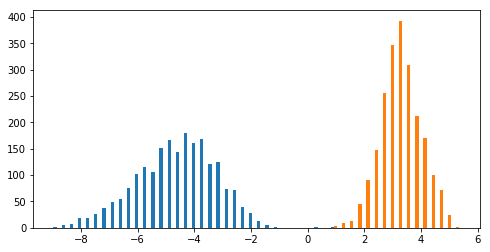

In [13]:
def mnist_pairwise_altproj(df, a, b, solver, test_size=0.5, verbose=False):
   #find all samples labeled with digit a and split into train/test sets
    Xa_tr, Xa_te, ya_tr, ya_te = extract_and_split(df, a, test_size)
    # Find all samples labeled with digit b and split into train/test sets
    Xb_tr, Xb_te, yb_tr, yb_te = extract_and_split(df, b, test_size)  
    #set the lable for all training and testig sets
    ya_tr = np.ones((ya_tr.shape[0],), dtype = np.int64)* -1
    ya_te = np.ones((ya_te.shape[0],), dtype = np.int64)* -1
    yb_tr = np.ones((yb_tr.shape[0],), dtype = np.int64)* 1
    yb_te = np.ones((yb_te.shape[0],), dtype = np.int64)* 1
    # Construct the full training set
    X_tr = np.vstack((Xa_tr,Xb_tr))
    y_tr = np.hstack((ya_tr,yb_tr)) 
    # Construct the full testing set
    X_te = np.vstack((Xa_te,Xb_te))
    y_te = np.hstack((ya_te,yb_te))
    # Run solver on training set to get linear classifier
    A_tilde = np.multiply(np.array([y_tr,]*X_tr.shape[1]).T, X_tr)
    z_hat, err = solver(A_tilde, np.ones(A_tilde.shape[0]))
    # Compute estimation and misclassification on training set
    y_hat_tr = X_tr@ z_hat
    err_tr = (np.sum(y_hat_tr[0 : ya_tr.size] > 0) + np.sum(y_hat_tr[ya_tr.size : ] < 0)) / y_hat_tr.size
    # Compute estimation and misclassification on testing set
    y_hat_te = np.matmul(X_te, z_hat)
    err_te = (np.sum(y_hat_te[0 : ya_te.size] > 0) + np.sum(y_hat_tr[ya_te.size : ] < 0)) / y_hat_te.size
    
    if verbose:
        print('Pairwise experiment, mapping {0} to -1, mapping {1} to 1'.format(a, b))
        print('training error = {0:.2f}%, testing error = {1:.2f}%'.format(100 * err_tr, 100 * err_te))
        
        # Compute confusion matrix for training set
        cm_tr = np.array([[np.sum(y_hat_tr[0 : ya_tr.size] < 0), np.sum(y_hat_tr[0 : ya_tr.size] > 0)],
                       [ np.sum(y_hat_tr[ya_tr.size : ] < 0),np.sum(y_hat_tr[ya_tr.size : ] > 0) ]])
        print('Training set confusion matrix:\n {0}'.format(cm_tr))
        
        # Compute confusion matrix for testing set
        cm_te = np.array([[np.sum(y_hat_te[0 : ya_te.size] < 0), np.sum(y_hat_te[0 : ya_te.size] > 0)],
                       [ np.sum(y_hat_te[ya_te.size : ] < 0),np.sum(y_hat_te[ya_te.size : ] > 0) ]])
        print('Testing set confusion matrix:\n {0}'.format(cm_te))
        # Compute the histogram of the function output separately for each class 
        # Then plot the two histograms together
        ya_te_hat , yb_te_hat =np.split(y_hat_te,2)
        output = [remove_outlier(ya_te_hat), remove_outlier(yb_te_hat)]
        plt.figure(figsize=(8, 4))
        plt.hist(output, bins=50)
    
    res = np.array([err_tr, err_te])
    return z_hat, res

solver = lambda A, b: lp_altproj(A, b + 1e-6, 100)
z_hat, res = mnist_pairwise_altproj(df, 0, 1, solver, verbose=True)

In [14]:
def Confusion_matrix(Y_hat_te_clean_up, y_te):
    # reverse one hot encoding to one result line:
    Y_hat_te = np.zeros((Y_hat_te_clean_up.shape[0], 1))
    for i in range(10):
        Y_hat_te[ Y_hat_te_clean_up[:, i] ==1] = i
    #crearte an empty matrix to hold the Confusion_matrix
    lable_size = Y_hat_te_clean_up.shape[1]
    cm = np.zeros((lable_size, lable_size))
    y_te = np.array([y_te]).T
    
    #fill in the matrix    
    for i in range(lable_size):
        #find the index of those predicted to be i
        predicted_i =  np.where(Y_hat_te ==i)[0]
        for j in range(lable_size):
            # find those predicted index's real lable and fill the table
            cm[i][j] = sum(y_te[predicted_i] == j)
    return cm.astype(int)

In [94]:
def mnist_multiclass_altproj(df, solver, test_size=0.5):
    """
    Experiment for applying least-square to classify all digits using one-hot encoding
    Arguments:
        df {dataframe} -- the dataframe of MNIST dataset
        solver {function} -- function to compute linear classifier
        test_size {float} -- the fraction of testing set, default value is 0.5
    Returns:
        Z {numpy.ndarray} -- coefficients for linear classifier
        res {numpy.ndarray} -- numpy.array([traing error, testing error])
    """
    # Split into training/testing set
    msk = np.random.rand(len(df)) < test_size
    tr, te = df[~msk], df[msk]
    
    # Construct the training set
    X_tr = np.concatenate(tr.loc[: ,'feature'].values).reshape(tr.shape[0], 784)
    #add in a colum of -1's
    last_column = np.array([np.ones((tr.shape[0],), dtype = np.int64)*-1]).T
    X_tr = np.hstack((X_tr,last_column)) 
    #constrcut the lable of training set
    y_tr = tr.loc[: ,'label'].values
    
    # Construct the testing set
    X_te = np.concatenate(te.loc[: ,'feature'].values).reshape(te.shape[0], 784)
    #add in a colum of -1's
    last_column = np.array([np.ones((te.shape[0],), dtype = np.int64)*-1]).T
    X_te = np.hstack((X_te,last_column))  
    #constrcut the lable of testing set
    y_te = te.loc[: ,'label'].values
    
    #above implimation come from pj2
    Y_tr_Hot = np.zeros((tr.shape[0], 10))
    Y_te_Hot = np.zeros((te.shape[0], 10))
    # then fill in the one-hot encoding if the # = i the i location is 1
    for i in range(10):
        Y_tr_Hot[y_tr == i,i] = 1
        Y_te_Hot[y_te == i,i] = 1
    
    # Run solver on training set to get linear classifier
    A_tilde = np.zeros(((10-1)*X_tr.shape[0], 10*X_tr.shape[1]))
    for i in tqdm(range( X_tr.shape[0] ), total = X_tr.shape[0], leave = False):
        xi = X_tr[i,:]*-1
        temp = 0
        for j in range (10):
            if j == y_tr[i]:
                continue
            else:
                A_tilde[i*9+temp, j*785 : (j+1)*785] = xi
                A_tilde[i*9+temp, y_tr[i]*785 : (y_tr[i]+1)*785] = X_tr[i,:]
                temp +=1
    b_tilde = np.zeros(A_tilde.shape[0])
    
    Z, err = solver(A_tilde, b_tilde)
    # Reshape Z as a 785 x 10 matrix
    Z = np.reshape(Z, (10,785)).T
    
    # Compute estimation and misclassification on training set
    y_hat_tr = np.matmul(X_tr,Z)
    #find the lable of the prediction 
    maxlocation_tr = np.argmax(y_hat_tr,axis=1) 
    # Y_hat_tr_clean_up cahnge the predicted able to 1 
    Y_hat_tr_clean_up = np.zeros((tr.shape[0], 10))
    for i in range(10):
        Y_hat_tr_clean_up[maxlocation_tr ==i, i] = 1
    # err_tr = 1 -  (correct hit/ all prediction)
    err_tr = 1- sum(np.all(Y_hat_tr_clean_up == Y_tr_Hot, axis=1))/len(Y_tr_Hot)
    
    # Compute estimation and misclassification on training set
    # Calculate the estimation on testing set
    y_hat_te = np.matmul(X_te,Z)
    #find the lable of the prediction 
    maxlocation_te = np.argmax(y_hat_te,axis=1) 
    # Y_hat_tr_clean_up cahnge the predicted able to 1 
    Y_hat_te_clean_up = np.zeros((te.shape[0], 10))
    for i in range(10):
        Y_hat_te_clean_up[maxlocation_te ==i, i] = 1
    err_te = 1- sum(np.all(Y_hat_te_clean_up == Y_te_Hot, axis=1))/len(Y_te_Hot)
    
    print('training error = {0:.2f}%, testing error = {1:.2f}%'.format(100 * err_tr, 100 * err_te))
    # Compute confusion matrix for training set
    cm_tr = Confusion_matrix(Y_hat_tr_clean_up, y_tr)
    print('Training set confusion matrix:\n {0}'.format(cm_tr))
    # Compute confusion matrix for testing set
    cm_te = Confusion_matrix(Y_hat_te_clean_up, y_te)
    print('Testing set confusion matrix:\n {0}'.format(cm_te))
    
    res = np.array([err_tr, err_te])
    return Z, res
solver = lambda A, b: lp_altproj(A, b + 1e-6, 100)
Z, res = mnist_multiclass_altproj(df, solver)

(189873, 7850)
(785,)


training error = 8.54%, testing error = 13.49%
Training set confusion matrix:
 [[1996    0    1    1    0   11   29    1    9    2]
 [   0 2270    4    2    0    3    4    3    5    0]
 [   8   30 1948   42    2   14   39   17   29    1]
 [  13   11   44 2091    2  127    4   25   84   11]
 [   7    3   48    9 2023   52   91   37   33   95]
 [  13    1    9   25    2 1510   56    5   52    2]
 [   1    0    4    0    0    8 1843    1    3    0]
 [   1    0    7    4    1    1    0 1904    2    6]
 [   5   38   32   41    3   83   20   10 1748    9]
 [   8    9   14   31   37   51    0  189   64 1963]]
Testing set confusion matrix:
 [[1975    2   14    4    2   40   28    4   16   11]
 [   0 2161   19    7    6    5    3    8   31    7]
 [  14   50 1783   59   12   23   62   27   54    4]
 [  24   19   80 1853    4  166    2   31   89   33]
 [   9    5   33    5 1855   58  101   56   40  147]
 [  25    6   19   65    1 1416   68    2   92    9]
 [   6    1   14    7   10   20 1757    1

v [1. 0.]
w [[0. 2.]
 [0. 0.]]
v [0.75592895 0.21137173]
w [[ 0.          2.        ]
 [-0.24407105  0.21137173]]
v [0.75592895 0.        ]
w [[ 0.          1.78862827]
 [-0.24407105  0.21137173]]
v [0.68029028 0.13308261]
w [[ 0.          1.78862827]
 [-0.31970972  0.34445434]]
v [0.68029028 0.        ]
w [[ 0.          1.65554566]
 [-0.31970972  0.34445434]]
v [0.63689601 0.09507568]
w [[ 0.          1.65554566]
 [-0.36310399  0.43953002]]
v [0.63689601 0.        ]
w [[ 0.          1.56046998]
 [-0.36310399  0.43953002]]
v [0.60807692 0.07214729]
w [[ 0.          1.56046998]
 [-0.39192308  0.51167731]]
v [0.60807692 0.        ]
w [[ 0.          1.48832269]
 [-0.39192308  0.51167731]]
v [0.58741625 0.05674044]
w [[ 0.          1.48832269]
 [-0.41258375  0.56841775]]
v [0.58741625 0.        ]
w [[ 0.          1.43158225]
 [-0.41258375  0.56841775]]
v [0.57188372 0.04569071]
w [[ 0.          1.43158225]
 [-0.42811628  0.61410846]]
v [0.57188372 0.        ]
w [[ 0.          1.38589154]
 

Text(0.5,1,'Zoom-in trajectories')

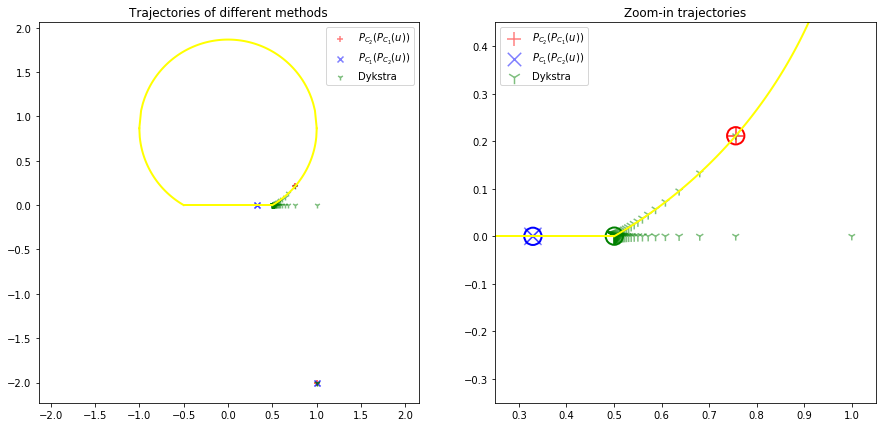

In [21]:
P_C1 = np.array([0,1])
P_C2 = np.array([0,np.sqrt(3)/2])
P = [P_C1, P_C2]

# Alternating Projection P_{C_2}(P_{C_1}(u))
us1 = [np.array([1.0, -2.0]), np.array([1.0, -2.0])]
while True:
    uk = proj_HS(us1[-2],P_C1,0)
    u = proj_NB(uk,1,P_C2)
    if np.linalg.norm(us1[-2] - u) >= 1e-4:
        us1.append(u)
    else:
        break
# Alternating Projection P_{C_1}(P_{C_2}(u))
us2 = [np.array([1.0, -2.0]), np.array([1.0, -2.0])]
while True:
    um = proj_NB(us2[-2],1,P_C2)
    u = proj_HS(um,P_C1,0)
    if np.linalg.norm(us2[-2] - u) >= 1e-4:
        us2.append(u)
    else:
        break
# Dykstra's Algorithm
vs, w = [np.array([1.0, -2.0]), np.array([1.0, -2.0])], np.zeros((2, 2))
while True:
    
    v = proj_HS(vs[-1]-w[0],P_C1,0) if len(vs)%2 == 0 else proj_NB(vs[-1]-w[1],1,P_C2)
    print('v',v)
    if len(vs)%2 == 0:
        w[0] = v-vs[-1]+w[0]
    else:
        w[1] = v-vs[-1]+w[1]
    print('w',w)                          
    if np.linalg.norm(vs[-2] - v) >= 1e-4:
        vs.append(v)
    else:
        break

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
# Plot half space part
x, y = np.linspace(-0.5, 0.5, 101), np.zeros(101)
plt.plot(x, y, color='yellow', linewidth=2)
# Plot unit ball part
x = np.linspace(-1, 1, 101)
y = np.sqrt(3)/2 + np.sqrt(1 - x**2)
plt.plot(x, y, color='yellow', linewidth=2)
x = np.linspace(-1, -0.5, 101)
y = np.sqrt(3)/2 - np.sqrt(1 - x**2)
plt.plot(x, y, color='yellow', linewidth=2)
x = np.linspace(0.5, 1, 101)
y = np.linspace(0.5, 1, 101)
plt.plot(x, np.sqrt(3)/2 - np.sqrt(1 - y**2), color='yellow', linewidth=2)
plt.scatter(*np.array(us1).T, c='red', marker='+', alpha=0.5, label=r'$P_{C_2}(P_{C_1}(u))$')
plt.scatter(*np.array(us2).T, c='blue', marker='x', alpha=0.5, label=r'$P_{C_1}(P_{C_2}(u))$')
plt.scatter(*np.array(vs).T, c='green', marker='1', alpha=0.5, label='Dykstra')
plt.axis('equal')
plt.legend()
plt.title('Trajectories of different methods')

plt.subplot(1, 2, 2)
# Plot half space part
x, y = np.linspace(-0.5, 0.5, 101), np.zeros(101)
plt.plot(x, y, color='yellow', linewidth=2)
# Plot unit ball part
x = np.linspace(-1, 1, 101)
y = np.sqrt(3)/2 + np.sqrt(1 - x**2)
plt.plot(x, y, color='yellow', linewidth=2)
x = np.linspace(-1, -0.5, 101)
y = np.sqrt(3)/2 - np.sqrt(1 - x**2)
plt.plot(x, y, color='yellow', linewidth=2)
x = np.linspace(0.5, 1, 101)
y = np.linspace(0.5, 1, 101)
plt.plot(x, np.sqrt(3)/2 - np.sqrt(1 - y**2), color='yellow', linewidth=2)
size = 300 * np.linspace(0.2, 1, len(us1))
plt.scatter(*np.array(us1).T, c='red', marker='+', s=size, alpha=0.5, label=r'$P_{C_2}(P_{C_1}(u))$')
plt.scatter(us1[-1][0], us1[-1][1], s=300, facecolors='none', edgecolors='red', linewidth=2)
size = 300 * np.linspace(0.2, 1, len(us2))
plt.scatter(*np.array(us2).T, c='blue', marker='x', s=size, alpha=0.5, label=r'$P_{C_1}(P_{C_2}(u))$')
plt.scatter(us2[-1][0], us2[-1][1], s=300, facecolors='none', edgecolors='blue', linewidth=2)
size = 300 * np.linspace(0.2, 1, len(vs))
plt.scatter(*np.array(vs).T, c='green', marker='1', s=size, alpha=0.5, label='Dykstra')
plt.scatter(vs[-1][0], vs[-1][1], s=300, facecolors='none', edgecolors='green', linewidth=2)
plt.xlim([0.25, 1.05])
plt.ylim([-0.35, 0.45])
plt.legend()
plt.title('Zoom-in trajectories')